Reference - [here](https://curiousily.com/posts/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python/)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Text(0.5, 1.0, 'Input sine with noise')

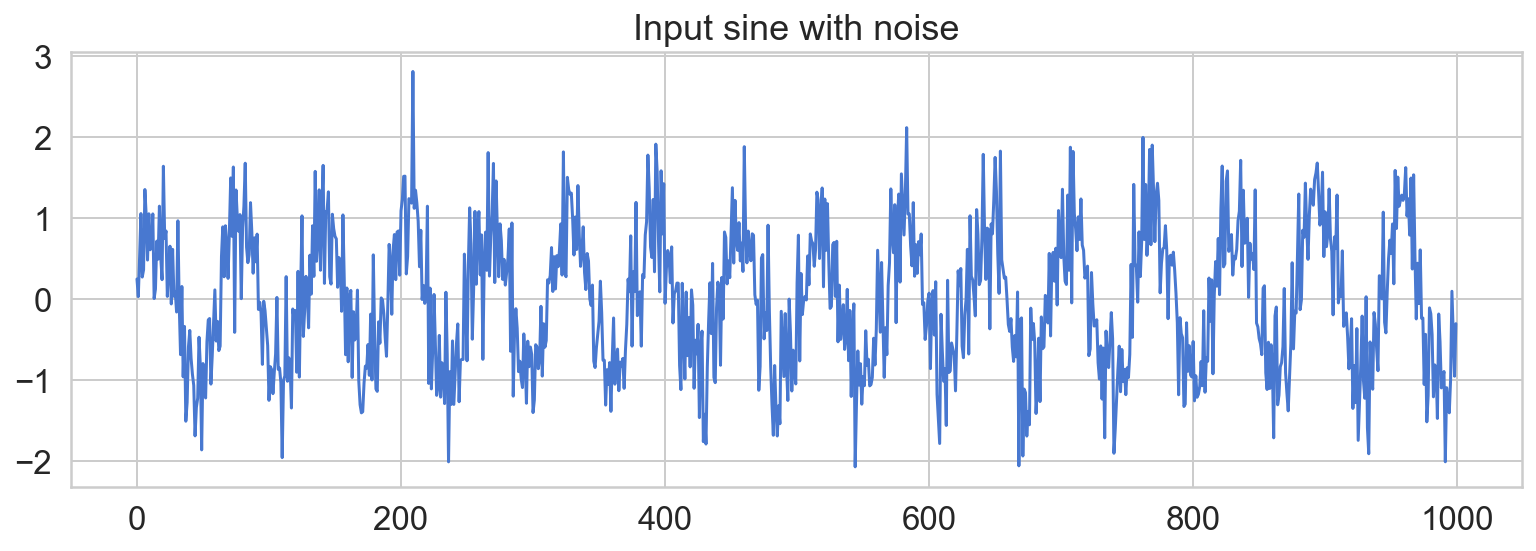

In [2]:
time = np.arange(0, 100, 0.1)
sin = np.sin(time) + np.random.normal(scale=0.5, size=len(time))

plt.figure(figsize=(13,4))
plt.plot(sin)
plt.title("Input sine with noise")

We need to “chop the data” into smaller sequences for our model. But first, we’ll split it into training and test data:

In [3]:
df = pd.DataFrame(dict(sine=sin), index=time, columns=['sine'])
df.head(4)

,sine
0.0,0.248357
0.1,0.030701
0.2,0.522514
0.3,1.057035


In [4]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

800 200


We need to predict the value at the current time step by using the history (n time steps from it). Here’s a generic function that does the job.

In [5]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
   
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    
    return np.array(Xs), np.array(ys)

The beauty of this function is that it works with univariate (single feature) and multivariate (multiple features) Time Series data.  
Let’s use a history of 10 time steps to make our sequences.

In [6]:
time_steps = 10

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.sine, time_steps)
X_test, y_test = create_dataset(test, test.sine, time_steps)

print(X_train.shape, y_train.shape)

(790, 10, 1) (790,)


We have our sequences in the shape **(samples, time_steps, features)**.  

### Modelling
Training an LSTM model in Keras is easy. We’ll use the LSTM layer in a sequential model to make our predictions

In [7]:
model = keras.Sequential()

model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))

model.add(keras.layers.Dense(units=1))

model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

The LSTM layer expects the number of time steps and the number of features to work properly. he rest of the model looks like a regular regression model.  

### Training
The most important thing to remember when training Time Series models is to not shuffle the data (the order of the data matters). 

In [9]:
history = model.fit(
    X_train, y_train,
    epochs = 30,
    batch_size = 16,
    validation_split=0.1,
    verbose = 1,
    shuffle=False
)

Epoch 1/30
45/45 [==============================] - 15s 61ms/step - loss: 0.4394 - val_loss: 0.3740
Epoch 2/30
45/45 [==============================] - 1s 15ms/step - loss: 0.3324 - val_loss: 0.3310
Epoch 3/30
45/45 [==============================] - 1s 14ms/step - loss: 0.3219 - val_loss: 0.3254
Epoch 4/30
45/45 [==============================] - 1s 15ms/step - loss: 0.3199 - val_loss: 0.3217
Epoch 5/30
45/45 [==============================] - 1s 15ms/step - loss: 0.3184 - val_loss: 0.3191
Epoch 6/30
45/45 [==============================] - 1s 14ms/step - loss: 0.3173 - val_loss: 0.3171
Epoch 7/30
45/45 [==============================] - 1s 14ms/step - loss: 0.3165 - val_loss: 0.3154
Epoch 8/30
45/45 [==============================] - 1s 15ms/step - loss: 0.3157 - val_loss: 0.3140
Epoch 9/30
45/45 [==============================] - 1s 14ms/step - loss: 0.3150 - val_loss: 0.3126
Epoch 10/30
45/45 [==============================] - 1s 14ms/step - loss: 0.3144 - val_loss: 0.3113
Epoch 11

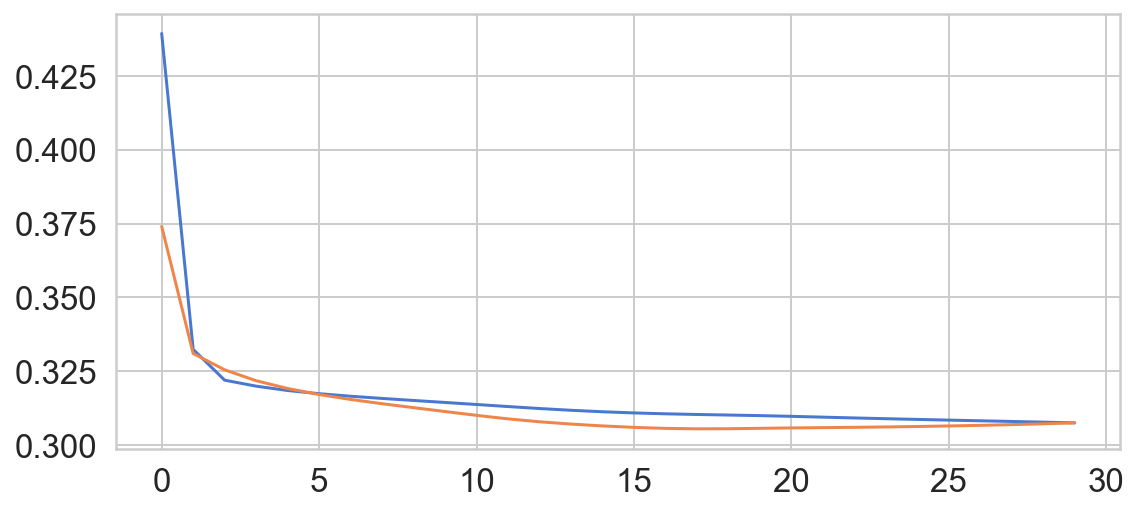

In [13]:
plt.figure(figsize=(9,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.show()

Our dataset is pretty simple and contains the randomness from our sampling. After about 15 epochs, the model is pretty much-done learning.  

### Evaluation
Let’s take some predictions from our model,

In [10]:
y_pred = model.predict(X_test)

We can plot the predictions over the true values from the Time Series

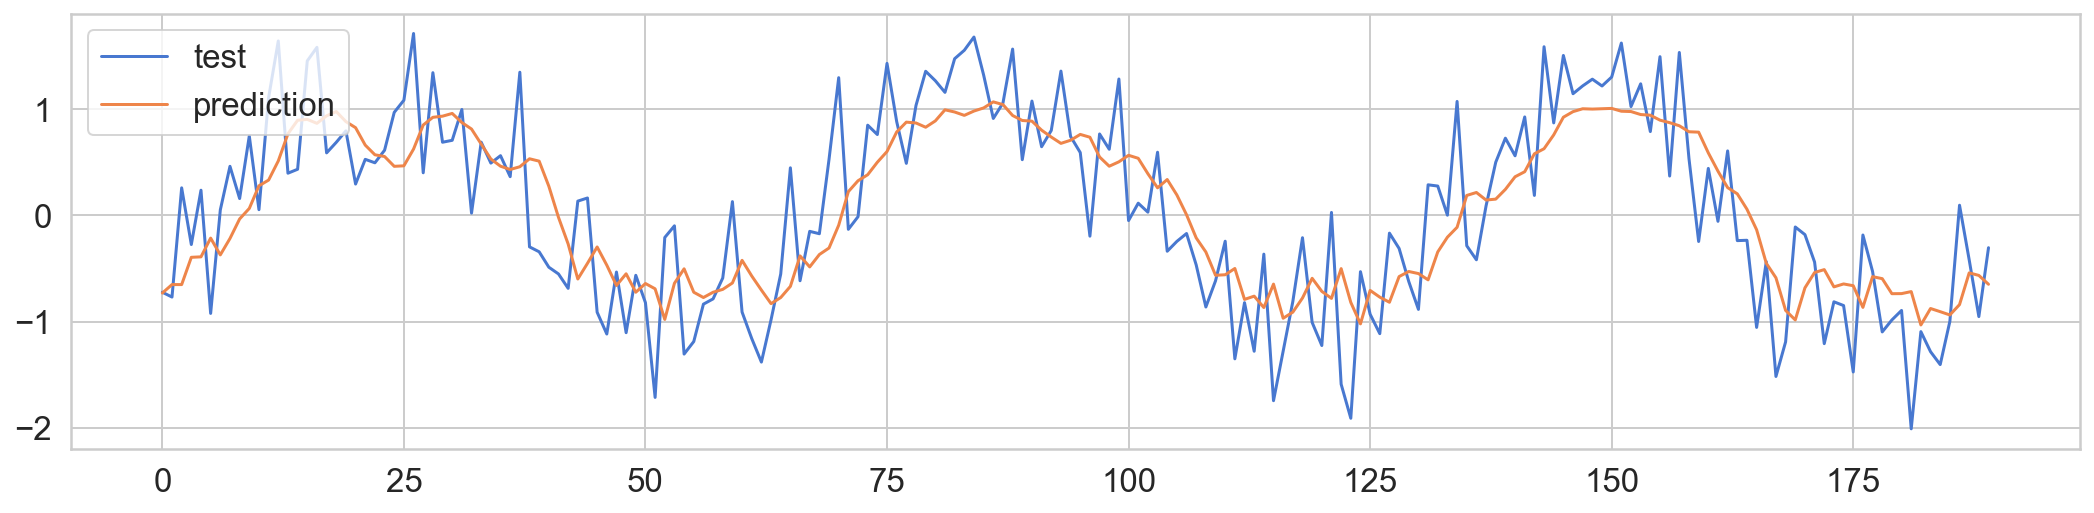

In [26]:
plt.figure(figsize=(18,4))
plt.plot(y_test, label="test")
plt.plot(y_pred, label="prediction")
plt.legend(loc= "upper left")
plt.show()

The model seems to be doing a great job of capturing the general pattern of the data. It fails to capture random fluctuations, which is a good thing (it generalizes well)